In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw
from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.io
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from eofs.standard import Eof

from dateutil        import parser
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
DEBUG:shapely.geos:Trying `CDLL(libgeos_c.so.1)`
DEBUG:shapely.geos:Trying `CDLL(libgeos_c.so)`
DEBUG:shapely.geos:Trying `CDLL(/home/ssahu/anaconda3/lib/libgeos_c.so)`
DEBUG:shapely.geos:Library path: '/home/ssahu/anaconda3/lib/libgeos_c.so'
DEBUG:shapely.geos:DLL: <CDLL '/home/ssahu/anaconda3/lib/libgeos_c.so', handle 357b300 at 0x7f8c446e7ba8>
DEBUG:shapely.geos:Trying `CDLL(libc.so.6)`
DEBUG:shapely.geos:Library path: 'libc.so.6'
DEBUG:shapely.geos:DLL: <CDLL 'libc.so.6', handle 7f8c9211e000 at 0x7f8c446e1208>


In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [7]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]





mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

# tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
# umask = mask.variables['umask'][0,:32,180:350, 480:650]
# vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
# mbathy = mask.variables['mbathy'][0,180:350, 480:650]

tmask = mask.variables['tmask'][0,:,220:280, 580:630]
umask = mask.variables['umask'][0,:,220:280, 580:630]
vmask = mask.variables['vmask'][0,:,220:280, 580:630]
mbathy = mask.variables['mbathy'][0,220:280, 580:630]


# y_wcvi_slice = np.array(np.arange(220,280))
# x_wcvi_slice = np.array(np.arange(590,650))
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# mbathy[mbathy>32] = 32

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']#[220:280, 580:630]
lat = bathy['nav_lat']#[220:280, 580:630]

In [3]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...];#[:,:,40:100,110:]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [8]:
isot[4]

26.4

In [9]:
def add_model_MVP_data(survey_file, iso_level, survey_iso_spic, model_spic):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]

    spic_rho_finite = spic_rho_finite[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    return survey_iso_spic, model_spic




In [10]:
survey_mat_file_A = '/data/ssahu/Falkor_2013/mvp/surveyA.mat'
survey_mat_file_B = '/data/ssahu/Falkor_2013/mvp/surveyB.mat'
survey_mat_file_D = '/data/ssahu/Falkor_2013/mvp/surveyD.mat'
survey_mat_file_E = '/data/ssahu/Falkor_2013/mvp/surveyE.mat'
survey_mat_file_G = '/data/ssahu/Falkor_2013/mvp/surveyG.mat'


all_surveys = [survey_mat_file_A, survey_mat_file_B, survey_mat_file_D, \
              survey_mat_file_E, survey_mat_file_G]

In [11]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

In [12]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

In [13]:
def get_stat(obs, model):
    
    model_interp = model

    obar = np.nanmean(obs)
    mprime = model_interp - obar
    oprime = obs - obar

    diff_sq = np.sum((model_interp-obs)**2)
    add_sq = np.sum((np.abs(mprime) + np.abs(oprime))**2)

    ws = 1-diff_sq/add_sq



    error = model_interp - obs
    gamma2 = np.var(error)/np.var(obs)
    mean_error = np.mean(error)
    mean_abs_error = np.mean(np.abs(error))
    rms_error = np.sqrt(np.mean(error**2))
    
    return gamma2,rms_error,ws



In [14]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):

        self.sg.fig.set_size_inches(self.fig.get_size_inches())

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [24]:
sns.set(font_scale=1.2)


### At the 26.4 isopycnal

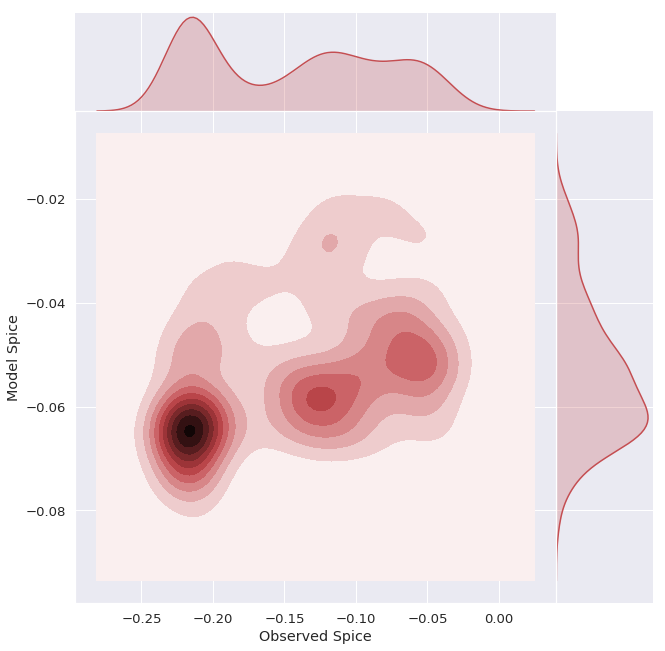

In [34]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10))
# gamma2,rms_error,ws = get_stat(df['Observed_Spice'], df['Model_Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax.transAxes
#                        )
# ax.set_xlim(-0.25,0)
# ax.set_ylim(-0.085,-0.01)
# ax.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




## After correction

In [35]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/short_NEP36_2013_along_isopycnal_larger_offshore_rho_correct_temp_improved.nc')
iso_spic = iso_NEP.variables['spiciness'][...];#[:,:,40:100,110:]

# iso_NEP_for_mask = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')
# iso_spic_for_mask = iso_NEP_for_mask.variables['spiciness'][...]


# m = np.ma.masked_where(np.isnan(iso_spic_for_mask), iso_spic_for_mask)
# iso_spic = np.ma.masked_array(iso_spic, m.mask)

# # spic_tzyx[np.isnan(spic_tzyx)] = 0
# spic_iso = np.ma.masked_invalid(iso_spic)

isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [38]:
isot[14]

26.4

In [39]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

In [44]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

### At the 26.4 isopycnal

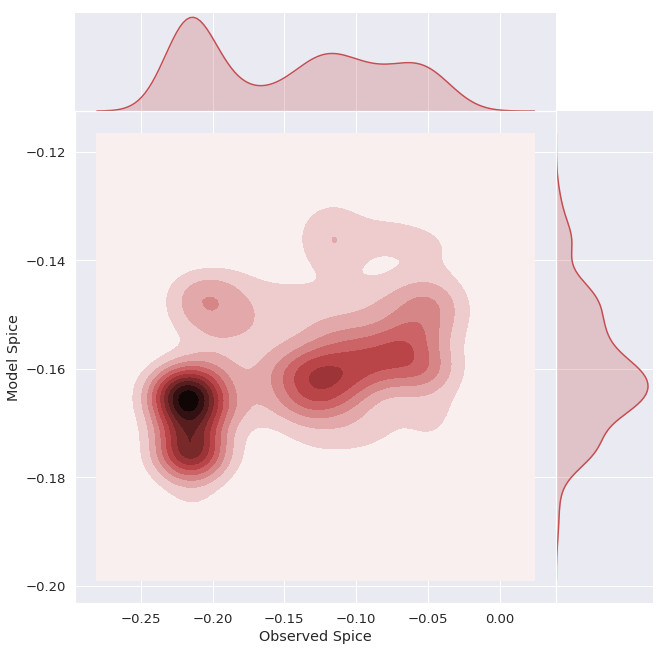

In [48]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10))
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax.transAxes
#                        )
# ax.set_xlim(-0.25,0)
# ax.set_ylim(-0.085,-0.01)
# ax.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




### At the 26.2 isopycnal

In [52]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=12,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

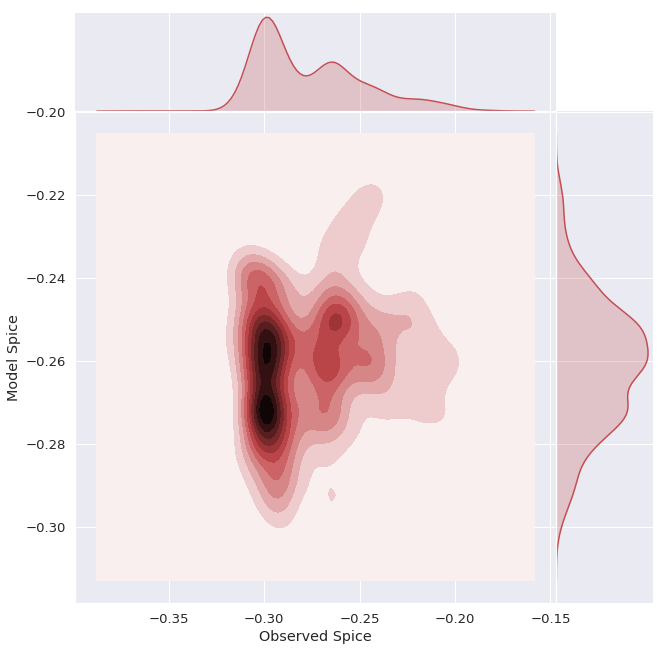

In [53]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10))
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax.transAxes
#                        )
# ax.set_xlim(-0.25,0)
# ax.set_ylim(-0.085,-0.01)
# ax.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




### At the 26.3 isopycnal

In [56]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=13,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

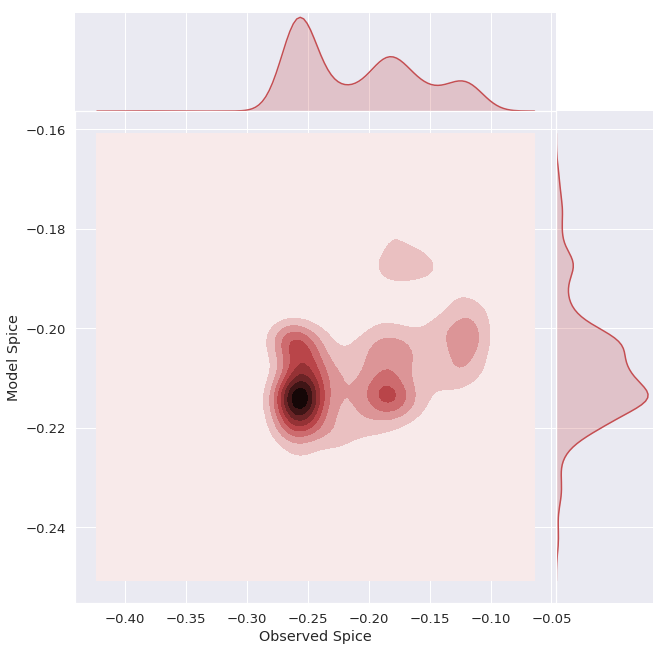

In [57]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10))
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax.transAxes
#                        )
# ax.set_xlim(-0.25,0)
# ax.set_ylim(-0.085,-0.01)
# ax.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [54]:
print(gamma2,rms_error,ws)

1.1296598751931626 0.0331911620405 0.47488098061176043


In [55]:
isot[13]

26.299999